In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.73G/3.75G [00:07<00:00, 410MB/s]
100% 3.75G/3.75G [00:07<00:00, 561MB/s]


In [4]:
!unzip 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [5]:
!pip install tensorflow


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [7]:
path = '/content/real_vs_fake/real-vs-fake'
size = (256, 256)


datagen = ImageDataGenerator(rescale=1./255.,
                              horizontal_flip=True)

train = datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 target_size=size,
                                                 batch_size=64
                                                )


Found 100000 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
val = test_datagen.flow_from_directory(path + '/valid',
                                  target_size=size,
                                  batch_size=64,
                                  class_mode='binary')
test = test_datagen.flow_from_directory(path + '/test',
                                    target_size=size,
                                    batch_size=64,
                                    class_mode='binary',
                                    shuffle=False)

Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [9]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.applications import DenseNet121
from keras.models import Sequential


densenet = DenseNet121(weights=None,
                           include_top=False,
                           input_shape=(256, 256, 3)
                          )

model = Sequential()

model.add(densenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',
                             patience=3,
                             restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='model.weights.h5',
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)



reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3)


history = model.fit(train,
                    validation_data=val,
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    epochs=20
                   )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 536s 236ms/step - accuracy: 0.6171 - loss: 0.6766 - val_accuracy: 0.5690 - val_loss: 0.8485 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 255s 163ms/step - accuracy: 0.8114 - loss: 0.4143 - val_accuracy: 0.8127 - val_loss: 0.4175 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 251s 161ms/step - accuracy: 0.8783 - loss: 0.2852 - val_accuracy: 0.8872 - val_loss: 0.2815 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 256s 164ms/step - accuracy: 0.9188 - loss: 0.2008 - val_accuracy: 0.8934 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 167ms/step - accuracy: 0.9402 - loss: 0.1512 - val_accuracy: 0.9083 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 236s 151ms/step - accuracy: 0.9575 - loss: 0.1112 - val_accuracy: 0.8911 - val_loss: 0.2730 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 256s 164ms

In [12]:
# Save model
model.save('final_model.h5')

# Download to local
from google.colab import files
files.download('final_model.h5')

# Optional: Save training history
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
files.download('training_history.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
model.save_weights("model_weights.weights.h5")


In [14]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

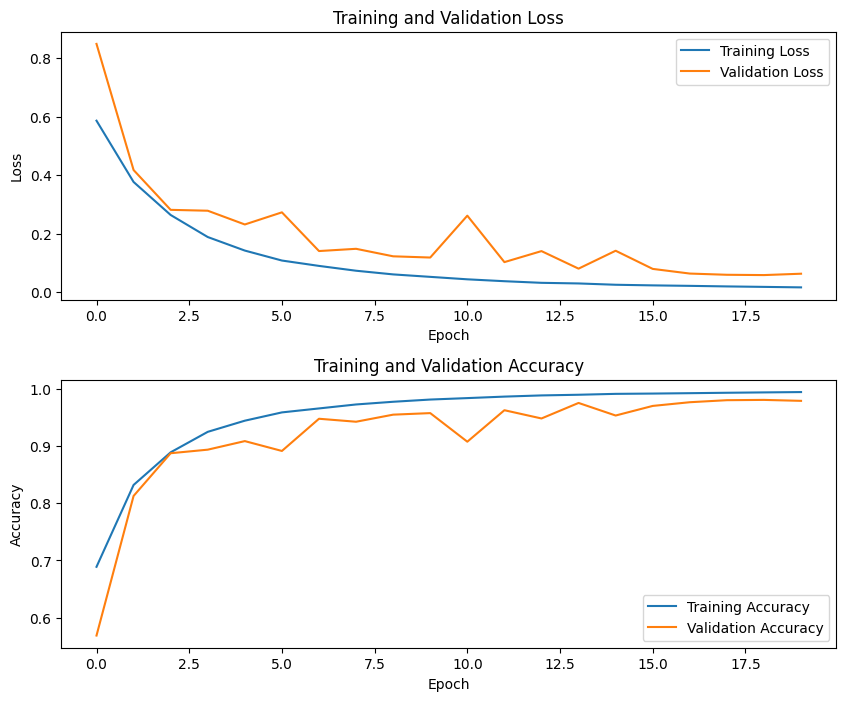

In [15]:

import matplotlib.pyplot as plt
import pandas as pd

loaded_history = pd.read_csv('training_history.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(loaded_history['loss'], label='Training Loss')
ax1.plot(loaded_history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.grid(False)

ax2.plot(loaded_history['accuracy'], label='Training Accuracy')
ax2.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.grid(False)
plt.subplots_adjust(hspace=0.3)
plt.savefig('training_metrics_plot.png')

plt.show()

In [16]:
accu = model.evaluate(test)[1]
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - accuracy: 0.9787 - loss: 0.0627
Final Test Acccuracy = 98.245


In [17]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [18]:

y_pred = model.predict(test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 158ms/step


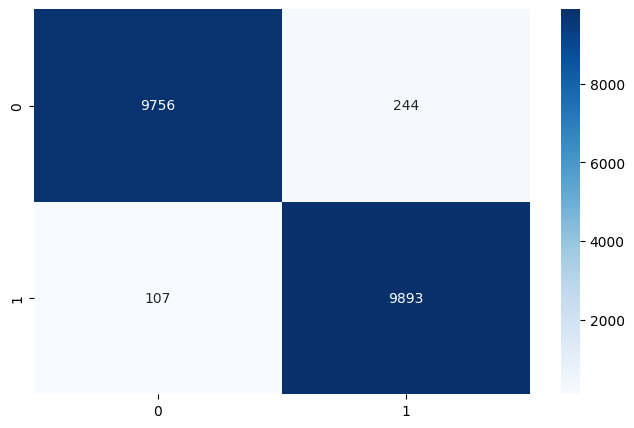

In [19]:
from sklearn import metrics
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(test.classes, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [20]:
print("ROC-AUC Score:", metrics.roc_auc_score(test.classes, y_pred.round()))
print("AP Score:", metrics.average_precision_score(test.classes, y_pred.round()))

ROC-AUC Score: 0.98245
AP Score: 0.9708373138009272


In [21]:
report = classification_report(test.classes, y_pred.round())
print('\nClassification Report')
print(report)


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10000
           1       0.98      0.99      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

